In [5]:
import instructor
import openai
from typing import List
from pydantic import BaseModel, Field

openai.api_base = "https://futu-002-caeast-001.openai.azure.com/"
openai.api_key = "5d050ffec2b94f5eb43c54c80149561e"
openai.api_version = "2023-07-01-preview"
openai.api_type = "azure"

# instructor.patch()
instructor.patch()

### 定义提取出的每一条数据的格式
- 简单来说每一条数据是Key-Value
- 单可以加上index, 因此其实是类似DataClass的结构, 定义了`每一条提取数据长什么样子`
    - index: int
    - data_type: str
    - data_value: str


In [2]:
class Data(BaseModel):
    index: int
    data_type: str
    data_value: str

### 定义最终返回的数据格式
- 他是一个object
- 他有一个字段`obj.trading_data`, 是list of Data

In [3]:
class Form144DataExtraction(BaseModel):
    """
    Extracted SEC Form 144 filing's key point data from a document, all data_types should try to have consistent property names
    """

    trading_data: List[Data]

    # def scrub_data(self, content):
    #     """
    #     Iterates over the Form 144 SEC filing data and replaces the value with a placeholder in the form of
    #     <{data_type}_{i}>
    #     """

    #     for i, data in enumerate(self.trading_data):
    #         content = content.replace(data.data_value, f"<{data.data_type}_{i}>")

    #     return content


In [ ]:
### 进行提取
EXAMPLE_DOCUMENT = """"""
rsp_data: Form144DataExtraction = openai.ChatCompletion.create(
    engine="gpt-4",
    response_model=Form144DataExtraction,
    messages=[
        {
            "role": "system",
            "content": "You are a world class SEC.gov Form 144 Extraction model, Extract the KeyField & Value data from the following document",
        },
        {
            "role": "user",
            "content": EXAMPLE_DOCUMENT,
        },
    ],
) 

### 内部处理流程
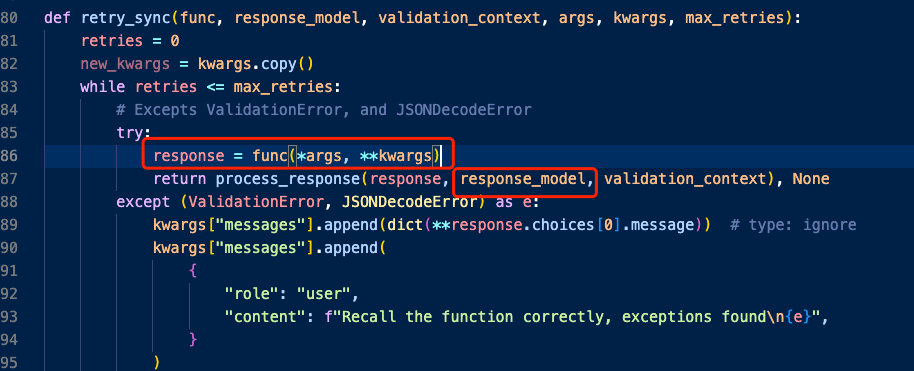
- 可以看到正常调用了openai.ChatCompletion的func
- 只是多了一步process_response()
    - 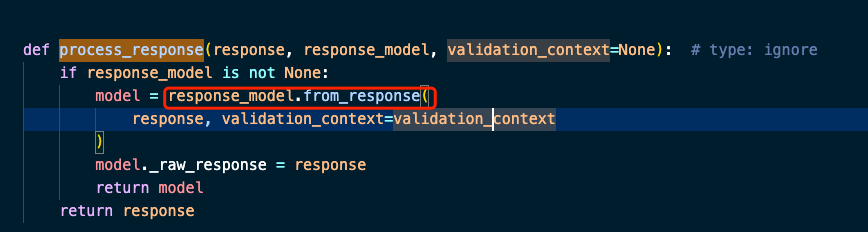
    - 此时我们设置了response_model=`Form144DataExtraction`, 这个类是BaseModel的子类
        - [from_response(completion_response)](https://github.com/lan2720/instructor/blob/5191283f868aac7df00c4f362ebc643685fafcac/instructor/function_calls.py#L101)位于instructor.function_calls.py
        - 它这个函数的作用是: Parse the response from OpenAI's API and `return the function call`
        - 它这个函数的返回值是: result (any): result of the `function call`
            - message = completion_response["choices"][0]["message"]就是真正的回复
            - message是一个dict
            - 先检查message中[是否有"function_call"](https://github.com/lan2720/instructor/blob/5191283f868aac7df00c4f362ebc643685fafcac/instructor/function_calls.py#L115C13-L115C75), 没有就会报错
            - 检查message["function_call"]["name"]是否等于self.openai_schema["name"]
            - message["function_call"]也是一个dict, 它有2个字段, "name"和"arguments", arguments是一个json string
            - 将arguments从json string转成dict: arguments = json.loads(function_call["arguments"], strict=False)
            - 验证arguments是否都是正确的: 
                - ```
                    from pydantic import validate_arguments
                    self.validate_func = validate_arguments(func)
                    self.validate_func(**arguments)
                    ```


In [ ]:
# print("Extracted Form 144 Data:")
# print(pii_data.model_dump_json(indent=2))

In [13]:
from instructor.function_calls import openai_function

@openai_function
def sum(a: int, b: int) -> int:
    return a + b

completion = openai.ChatCompletion.create(
    engine="gpt-4",
    messages=[{
        "content": "What is 1 + 1?",
        "role": "user"
    }]
)
sum.from_response(completion)

AssertionError: No function call detected

In [8]:
from instructor import OpenAISchema
from typing import List, Union
from langchain.document_loaders import UnstructuredFileLoader
from pydantic import BaseModel, StrictStr, Json

class Property(OpenAISchema):
    key: str = Field(description="The name of the property which is displayed in the document")
    value: Json = Field(description="The value corresponding to the key and recheck the value by the relationship between the key and value and surrounding context, value can be a JSON str if necessary",
                        examples=["{\"title\":\"Common\",\"date_acquired\":\"06/05/2021\",\"nature_of_acquisition\":\"Restricted Stock\",\"acquired_from\":\"Issuer\",\"amount\":\"399\"}"])
    # value: Union[StrictStr, Json] = Field(description="The value corresponding to the key and recheck the value by the relationship between the key and value and surrounding context, value can be a JSON str if necessary",
    #                    examples=["09/05/2023", 
    #                              "{\"title\":\"Common\",\"date_acquired\":\"06/05/2021\",\"nature_of_acquisition\":\"Restricted Stock\",\"acquired_from\":\"Issuer\",\"amount\":\"399\"}"])

class Form144DataExtraction(BaseModel):
    """
    Extracted SEC Form 144 filing's key point data from a document, all data_types should try to have consistent property names
    """

    trading_data: List[Property] = Field(description="Extract any properties that might be used to describe the trading, including tradings log in history, if applicable")

EXAMPLE_DOCUMENT = open("/data/home/jarvixwang/project/filings_gpt/output/unstruct_modified.txt").read()

# pdf_filepath = "/data/home/jarvixwang/project/filings_gpt/data/20231020评测集/股票交易_144_美股_TSLA_特斯拉：拟议出售证券_英文_0/primary_doc.xml.pdf"
# loader = UnstructuredFileLoader(pdf_filepath, mode="single")
# docs = loader.load()
# EXAMPLE_DOCUMENT = docs[0].page_content
# print(doc_text)

rsp_data: Form144DataExtraction = openai.ChatCompletion.create(
    engine="gpt-4",
    response_model=Form144DataExtraction,
    messages=[
        {
            "role": "system",
            "content": "You are a world class SEC.gov Form 144 Extraction model, Extract the KeyField & Value data from the following document",
        },
        {
            "role": "user",
            "content": EXAMPLE_DOCUMENT,
        },
    ],
)
print("Extracted Form 144 Data:")
print(rsp_data.model_dump_json(indent=2))
# completion = openai.ChatCompletion.create(
#     engine="gpt-4",
#     messages=[{
#         "content": "Jason is 20 years old",
#         "role": "user"
#     }],
#     functions=[User.openai_schema],
#     function_call={"name": User.openai_schema["name"]},
# )

# user = User.from_response(completion)
# print(user)

InvalidRequestError: 'content' is a required property - 'messages.2'